In [1]:
import os
import numpy as np
import time
import copy
import sys
import re

import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import atomistic_tools.cp2k_stm_utilities as csu

In [2]:
#folder = "/home/kristjan/local_work/morbs_test/cp2k_basis_test/"
#file_basis_set = folder + "BASIS_SET"
#file_xyz = folder + "h2.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"

folder = "/home/kristjan/local_work/morbs_test/c/"
file_basis_set = folder + "BR"
file_xyz = folder + "p.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

#folder = "/home/kristjan/local_work/morbs_test/c2h2/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "p.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "out"

In [3]:
emin = -20.0
emax =  20.0

In [4]:
time1 = time.time()
elem_basis_names, cell = csu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = csu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
ase_atoms = csu.read_xyz(file_xyz)
csu.center_atoms_to_cell(ase_atoms.positions, cell/ang_2_bohr)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, homo_inds, ref_en = csu.load_restart_wfn_file(file_restart, emin, emax)
print("Found %d orbitals" % len(morb_energies[0]))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.008
Read basis sets: 0.017
Read xyz: 0.008
S0 nmo: 12, [eV] H-1 -12.49386142 Homo -3.96467111 H+1 -3.96467111
Found 8 orbitals
Read restart: 0.005


In [5]:
homo_inds

[[1], [2], [4]]

In [8]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.08 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# Other possiblity: define cell_n directly
cell_n = np.array([75, 75, 75])

In [10]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [15]:
morb_grids = csu.calc_morbs_in_region(cell, cell_n,
                                      ase_atoms,
                                      basis_sets, morb_composition,
                                      x_eval_region = x_eval_region,
                                      y_eval_region = y_eval_region,
                                      z_eval_region = z_eval_region,
                                      eval_cutoff = 14.0
                                     )

Global cell:  [75 75 75]
Eval cell:  [75 75 75]
local cell:  [210 210 210]
---- Setup: 0.3639
---- Radial calc time : 22.170908
---- Spherical calc time : 1.516677
---- Loc -> loc_morb time : 5.838144
---- loc_morb -> glob time : 0.579899
---- Total time: 31.0696


In [16]:
print("Spins:", len(morb_grids))
morb_grids[0].shape

Spins: 1


(8, 75, 75, 75)

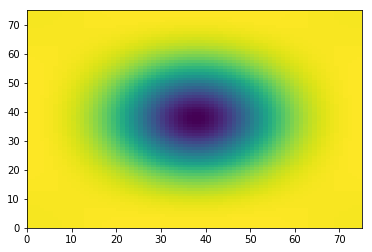

In [17]:
plt.pcolormesh(morb_grids[0][0][:, :, 60].T)
plt.show()

In [18]:
save_morb = morb_grids_new[0][1]

csu.write_cube_file("/home/kristjan/local_work/morbs_test/test.cube",
                   ase_atoms, new_cell, save_morb.shape, save_morb, origin = origin)

In [19]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids_new[0][0]**2)*vol_elem

0.9999402043823129